In [8]:
import configparser
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

from esda.adbscan import ADBSCAN, get_cluster_boundary, remap_lbls
import contextily as cx

In [50]:
rel_path = './../'

# read local config.ini file
config = configparser.ConfigParser()
config.read(rel_path + 'config.ini')

# get from config.ini
dir_output = rel_path + config['FILE_SETTINGS']['DIR_OUTPUT']
gpkg_src = dir_output + config['FILE_SETTINGS']['GPKG_NAME']
gpkg_cluster = dir_output + config['FILE_SETTINGS']['GPKG_NAME_CLU']

In [12]:
# read preprocessed files
db = gpd.read_file(gpkg_src, layer='bike_accidents_ext', 
                   ignore_fields=['UJAHR', 'UMONAT', 'USTUNDE', 'UWOCHENTAG', 
                                  'UART', 'UTYP1', 
                                  'IstRad', 'IstPKW', 'IstFuss', 'IstKrad', 'IstGkfz', 'IstSonstig'
                                 ])

195.57

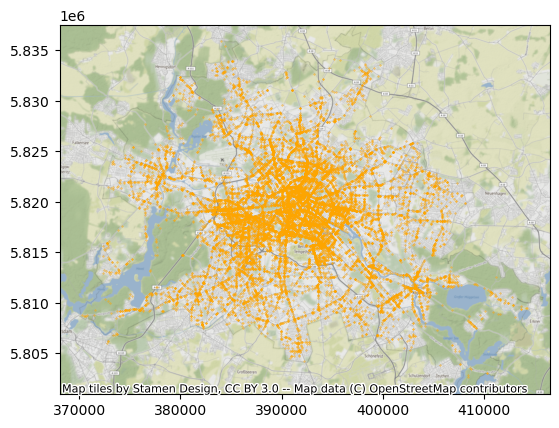

In [13]:
#ax = db.plot(markersize=0.1, color='orange')
#cx.add_basemap(ax, crs=db.crs.to_string())
# plt.show()

db["X"] = db.geometry.x
db["Y"] = db.geometry.y

db.shape[0] * 0.01

In [57]:
%%time
# Get clusters
adbs = ADBSCAN(200, 60, pct_exact=0.5, reps=10, keep_solus=True)
np.random.seed(1234)
adbs.fit(db)

# ax = db.assign(lbls=adbs.votes["lbls"]).plot(column="lbls",categorical=True,markersize=2.5,figsize=(12, 12))
# cx.add_basemap(ax, crs=db.crs.to_string())
# plt.show()

polys = get_cluster_boundary(adbs.votes["lbls"], db, crs=db.crs)


CPU times: total: 3.02 s
Wall time: 5.85 s


In [58]:
len(polys)

10

In [ ]:
#polys = get_cluster_boundary(adbs.votes["lbls"], db, crs=db.crs)


plt.rcParams['figure.figsize'] = [10, 15]

ax = polys.plot(alpha=0.5, color="red")
ax.set_title("Test")
ax.set_axis_off()

cx.add_basemap(ax, crs=polys.crs.to_string(), source=cx.providers.Stamen.TonerLite)

In [52]:
gdf = gpd.GeoDataFrame(geometry=polys)
polys_x_acc = gpd.sjoin(db, gdf, how='inner', predicate='intersects')
res = polys_x_acc.groupby(['index_right'])['index_right'].count()
gdf = gdf.join(res)

gdf.to_file(gpkg_cluster, layer='acc_all', driver='GPKG')